<a href="https://colab.research.google.com/github/bongbong31/aiffel/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.17.0
1.26.4


In [8]:
from PIL import Image
import glob
import os

In [9]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [10]:
# 이미지 사이즈 변경
def resize_images(img_path):
    images=glob.glob(img_path + '/*.jpg')

    print(len(images), 'images to be resized.')

    # 파일마다 사이즈 모두 28*28로 바꿔 저장
    target_size = (28,28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, 'JPEG')

    print(len(images), 'images resized.')

In [27]:
!mkdir -p /content/rsp_data

In [28]:
!mkdir -p /content/rsp_data/rock
!mkdir -p /content/rsp_data/scissor
!mkdir -p /content/rsp_data/paper

In [29]:
!unzip /content/rock.zip -d /content/rsp_data/rock
!unzip /content/scissor.zip -d /content/rsp_data/scissor
!unzip /content/paper.zip -d /content/rsp_data/paper

Archive:  /content/rock.zip
   creating: /content/rsp_data/rock/rock/
  inflating: /content/rsp_data/rock/__MACOSX/._rock  
  inflating: /content/rsp_data/rock/rock/63.jpg  
  inflating: /content/rsp_data/rock/__MACOSX/rock/._63.jpg  
  inflating: /content/rsp_data/rock/rock/189.jpg  
  inflating: /content/rsp_data/rock/__MACOSX/rock/._189.jpg  
  inflating: /content/rsp_data/rock/rock/77.jpg  
  inflating: /content/rsp_data/rock/__MACOSX/rock/._77.jpg  
  inflating: /content/rsp_data/rock/rock/162.jpg  
  inflating: /content/rsp_data/rock/__MACOSX/rock/._162.jpg  
  inflating: /content/rsp_data/rock/rock/176.jpg  
  inflating: /content/rsp_data/rock/__MACOSX/rock/._176.jpg  
  inflating: /content/rsp_data/rock/rock/88.jpg  
  inflating: /content/rsp_data/rock/__MACOSX/rock/._88.jpg  
  inflating: /content/rsp_data/rock/rock/177.jpg  
  inflating: /content/rsp_data/rock/__MACOSX/rock/._177.jpg  
  inflating: /content/rsp_data/rock/rock/89.jpg  
  inflating: /content/rsp_data/rock/__MAC

In [30]:
!rm -r /content/rsp_data/rock/__MACOSX
!rm -r /content/rsp_data/scissor/__MACOSX
!rm -r /content/rsp_data/paper/__MACOSX

In [31]:
!mv /content/rsp_data/rock/rock/* /content/rsp_data/rock
!mv /content/rsp_data/scissor/scissor/* /content/rsp_data/scissor
!mv /content/rsp_data/paper/paper/* /content/rsp_data/paper

In [32]:
!rm -r /content/rsp_data/paper/paper
!rm -r /content/rsp_data/rock/rock
!rm -r /content/rsp_data/scissor/scissor

In [34]:
# 데이터 구조
#!ls -R /content/rsp_data

In [35]:
# 사이즈 변경
resize_images('/content/rsp_data/rock')
resize_images('/content/rsp_data/scissor')
resize_images('/content/rsp_data/paper')

200 images to be resized.


<ipython-input-10-df42fc931fbd>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


200 images resized.
200 images to be resized.
200 images resized.
200 images to be resized.
200 images resized.


In [38]:
# 가위, 바위, 보 읽을 수 있는 load_data()
import numpy as np
import glob
from PIL import Image

def load_data(img_path, number_of_data=600):
    img_size = 28
    color = 3

    # 이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역 생성
    imgs = np.zeros((number_of_data, img_size, img_size, color), dtype=np.int32)
    labels = np.zeros(number_of_data, dtype=np.int32)

    idx = 0
    for label, category in enumerate(['rock', 'scissor', 'paper']):
        for file in glob.iglob(f'{img_path}/{category}/*.jpg'):
            if idx >= number_of_data:
                break
            img = np.array(Image.open(file).resize((img_size, img_size)), dtype=np.int32)
            imgs[idx] = img  # 수정된 부분: 직접 할당
            labels[idx] = label
            idx += 1
        if idx >= number_of_data:
            break

    print('학습데이터(x_train)의 이미지 개수는 ', idx, '입니다.')
    return imgs[:idx], labels[:idx]  # 실제 로드된 이미지 수만큼만 반환

In [39]:
(x_train, y_train)=load_data('/content/rsp_data')
x_train_norm = x_train/255.0 # 0~1사이의 값으로 정규화

print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}'.format(y_train.shape))

학습데이터(x_train)의 이미지 개수는  600 입니다.
x_train shape : (600, 28, 28, 3)
y_train shape : (600,)


label:  0


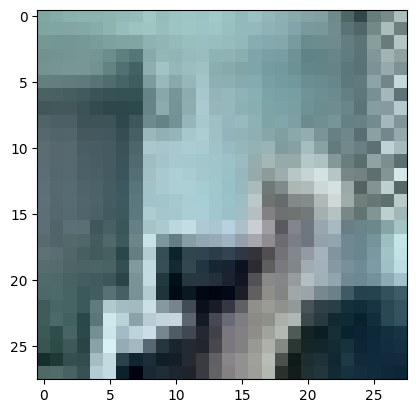

In [40]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('label: ', y_train[0])

# 딥러닝 네트워크 설계

In [41]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 128
n_train_epoch = 10

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,707 (877.76 KB)

 Trainable params: 224,707 (877.76 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# 딥러닝 네트워크 학습시키기
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# fit
model.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3538 - loss: 25.3491
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6347 - loss: 0.9454
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8511 - loss: 0.4847
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9747 - loss: 0.1688
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9925 - loss: 0.0610
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9973 - loss: 0.0388
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9988 - loss: 0.0189
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9996 - loss: 0.0098
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0109
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0052


# model test

In [43]:
!mkdir -p /content/test_data

In [44]:
!mkdir -p /content/test_data/rock_test
!mkdir -p /content/test_data/scissor_test
!mkdir -p /content/test_data/paper_test

In [45]:
!unzip /content/rock_test.zip -d /content/test_data/rock
!unzip /content/scissor_test.zip -d /content/test_data/scissor
!unzip /content/paper_test.zip -d /content/test_data/paper

Archive:  /content/rock_test.zip
   creating: /content/test_data/rock/rock/
  inflating: /content/test_data/rock/__MACOSX/._rock  
  inflating: /content/test_data/rock/rock/63.jpg  
  inflating: /content/test_data/rock/__MACOSX/rock/._63.jpg  
  inflating: /content/test_data/rock/rock/77.jpg  
  inflating: /content/test_data/rock/__MACOSX/rock/._77.jpg  
  inflating: /content/test_data/rock/rock/88.jpg  
  inflating: /content/test_data/rock/__MACOSX/rock/._88.jpg  
  inflating: /content/test_data/rock/rock/89.jpg  
  inflating: /content/test_data/rock/__MACOSX/rock/._89.jpg  
  inflating: /content/test_data/rock/rock/76.jpg  
  inflating: /content/test_data/rock/__MACOSX/rock/._76.jpg  
  inflating: /content/test_data/rock/rock/62.jpg  
  inflating: /content/test_data/rock/__MACOSX/rock/._62.jpg  
  inflating: /content/test_data/rock/rock/74.jpg  
  inflating: /content/test_data/rock/__MACOSX/rock/._74.jpg  
  inflating: /content/test_data/rock/rock/60.jpg  
  inflating: /content/test_

In [46]:
!rm -r /content/test_data/rock/__MACOSX
!rm -r /content/test_data/scissor/__MACOSX
!rm -r /content/test_data/paper/__MACOSX

In [50]:
!mv /content/test_data/rock/rock/* /content/test_data/rock_test
!mv /content/test_data/scissor/scissors/* /content/test_data/scissor_test
!mv /content/test_data/paper/paper/* /content/test_data/paper_test

mv: cannot stat '/content/test_data/rock/rock/*': No such file or directory
mv: cannot stat '/content/test_data/paper/paper/*': No such file or directory


In [51]:
! rm -r /content/test_data/paper
! rm -r /content/test_data/rock
! rm -r /content/test_data/scissor

test 데이터 이미지 reshape

In [52]:
resize_images('/content/test_data/rock_test')
resize_images('/content/test_data/scissor_test')
resize_images('/content/test_data/paper_test')

100 images to be resized.


<ipython-input-10-df42fc931fbd>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


100 images resized.
100 images to be resized.
100 images resized.
100 images to be resized.
100 images resized.


In [56]:
def load_test_data(img_path, number_of_data=300):
    img_size = 28
    color = 3

    # 이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역 생성
    imgs = np.zeros((number_of_data, img_size, img_size, color), dtype=np.int32)
    labels = np.zeros(number_of_data, dtype=np.int32)

    idx = 0
    for label, category in enumerate(['rock_test', 'scissor_test', 'paper_test']):
        for file in glob.iglob(f'{img_path}/{category}/*.jpg'):
            if idx >= number_of_data:
                break
            img = np.array(Image.open(file).resize((img_size, img_size)), dtype=np.int32)
            imgs[idx] = img  # 수정된 부분: 직접 할당
            labels[idx] = label
            idx += 1
        if idx >= number_of_data:
            break

    print('학습데이터(x_train)의 이미지 개수는 ', idx, '입니다.')
    return imgs[:idx], labels[:idx]  # 실제 로드된 이미지 수만큼만 반환

In [57]:
(x_test, y_test)=load_test_data('/content/test_data')
x_test_norm = x_test/255.0 # 0~1사이의 값으로 정규화

print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))

학습데이터(x_train)의 이미지 개수는  300 입니다.
x_test shape : (300, 28, 28, 3)
y_test shape : (300,)


### test model 훈련 및 예측

In [58]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print('test_loss: {}'.format(test_loss))
print('test_accuracy: {}'.format(test_accuracy))

10/10 - 0s - 29ms/step - accuracy: 0.3333 - loss: 7.4750
test_loss: 7.4750237464904785
test_accuracy: 0.3333333432674408
